In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing as sk
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

# Hide all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def clean_rate(dataframe):
    dataframe = re.sub('/5', '',str(dataframe)) #Replacing all ratings to a single value
    dataframe = re.sub('-', 'nan', str(dataframe)) #Replacing all values containing '-' with 0 rating since the number of votes are also 0
    dataframe = re.sub('NEW', 'nan', str(dataframe)) #Replacing all values containing 'NEW' with 0 rating since the number of votes are also 0 and the restaurant is new
    return float(dataframe)

In [3]:
def clean_approx_cost(dataframe):
    dataframe = re.sub(',','', str(dataframe))
    return dataframe

In [4]:
def scale_to_zero_mean_and_unit_variance(column):
    scaled_data = np.array(sk.scale(column))
    scaled_data = np.reshape(scaled_data,(scaled_data.shape[0],1))
    return scaled_data

In [5]:
def one_hot_encoding_of_column(column):
    # First, use LabelEncoder to convert Strings to numeric values as OHE does not accept Strings
    lab_enc = sk.LabelEncoder()
    lab_enc.fit(column)
    label_encoded = lab_enc.transform(column)
    
    # Reshape the label_encoded array into a Nx1 matrix as OHE requires a 2-D matrix as input
    label_encoded = np.reshape(label_encoded, (label_encoded.shape[0],1))
    
    # Perform One-Hot-Encoding
    OHE_encoder = sk.OneHotEncoder(sparse=False)
    OHE_encoder.fit(label_encoded)
    OHE_result = OHE_encoder.transform(label_encoded)

    return OHE_result

In [6]:
def multi_label_binarize_column(column):
    mlb = MultiLabelBinarizer()
    mlb_binarized = mlb.fit_transform(column)
    return mlb_binarized

In [7]:
def preprocess_data(data):

    # Scale the rate column
    clean_data = scale_to_zero_mean_and_unit_variance(data[:,0])
    
    # One-hot-encode the location column
    location_column_clean = one_hot_encoding_of_column(data[:,1])
    clean_data = np.append(clean_data, location_column_clean, axis=1)
    
    # Encode rest-type column using multi label binarizer
    rest_type_column_clean = multi_label_binarize_column(data[:,2])
    clean_data = np.append(clean_data, rest_type_column_clean, axis=1)
    
    # Encode cuisines column using multi label binarizer
    cuisines_column_clean = multi_label_binarize_column(data[:,3])
    clean_data = np.append(clean_data, cuisines_column_clean, axis=1)   
    
    return clean_data

In [8]:
def preprocess_relief_data(data):

    # Scale the rate column
    clean_data = one_hot_encoding_of_column(data[:,0])
    
    # One-hot-encode the location column
    online_order_column_clean = one_hot_encoding_of_column(data[:,1])
    clean_data = np.append(clean_data, online_order_column_clean, axis=1)
    
    # One-hot-encode the location column
    book_table_column_clean = one_hot_encoding_of_column(data[:,2])
    clean_data = np.append(clean_data, book_table_column_clean, axis=1)
    
    rate_column_clean = scale_to_zero_mean_and_unit_variance(data[:,3])
    clean_data = np.append(clean_data, rate_column_clean, axis=1)
    
    votes_column_clean = scale_to_zero_mean_and_unit_variance(data[:,4])
    clean_data = np.append(clean_data, votes_column_clean, axis=1)
    
    location_column_clean = one_hot_encoding_of_column(data[:,5])
    clean_data = np.append(clean_data, location_column_clean, axis=1)
    
    rest_type_column_clean = multi_label_binarize_column(data[:,6])
    clean_data = np.append(clean_data, rest_type_column_clean, axis=1)
    
    cuisines_column_clean = multi_label_binarize_column(data[:,7])
    clean_data = np.append(clean_data, cuisines_column_clean, axis=1)
    
    # Encode rest-type column using multi label binarizer
    listed_in_type_column_clean = one_hot_encoding_of_column(data[:,8])
    clean_data = np.append(clean_data, listed_in_type_column_clean, axis=1)
    
    # Encode cuisines column using multi label binarizer
    listed_in_city_column_clean = one_hot_encoding_of_column(data[:,9])
    clean_data = np.append(clean_data, listed_in_city_column_clean, axis=1)  
    
    return clean_data

## 1. Introduction

a.

## 2. Data pre-processing

In [9]:
# Load the data
df = pd.read_csv('zomato.csv', encoding='utf-8')
print(df.shape)
# Use original_df for relief without dropping any column
original_df = df
# Use df to consider only the four attributes listed in Question 3
df = df.drop(columns=['url','phone','reviews_list','menu_item','listed_in(city)', 'dish_liked', 'votes'])
print(df.shape)
print(df.columns)
print(original_df.shape)
print(original_df.columns)

df.to_csv('out.csv', encoding='utf-8', index=False)

(51717, 17)
(51717, 10)
Index(['address', 'name', 'online_order', 'book_table', 'rate', 'location',
       'rest_type', 'cuisines', 'approx_cost(for two people)',
       'listed_in(type)'],
      dtype='object')
(51717, 17)
Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')


In [10]:
df['rate'] = df['rate'].apply(clean_rate)
df['rate'] = df['rate'].fillna(df['rate'].mean())
df.dropna(subset=['location','rest_type','cuisines','approx_cost(for two people)'], inplace=True)
df['approx_cost(for two people)'] = df['approx_cost(for two people)'].apply(clean_approx_cost)
df = df.drop_duplicates(subset=['name','address'], keep='first')
print(df.shape)

(12382, 10)


In [11]:
df.rate.dtype

dtype('float64')

In [12]:
original_df['rate'] = original_df['rate'].apply(clean_rate)
original_df['rate'] = original_df['rate'].fillna(original_df['rate'].mean())
original_df.dropna(subset=['location', 'cuisines','rest_type','approx_cost(for two people)'], inplace=True)
original_df['approx_cost(for two people)'] = original_df['approx_cost(for two people)'].apply(clean_approx_cost)
original_df = original_df.drop_duplicates(subset=['name','address'], keep='first')
print(original_df.shape)

(12382, 17)


In [13]:
list(df.columns)

['address',
 'name',
 'online_order',
 'book_table',
 'rate',
 'location',
 'rest_type',
 'cuisines',
 'approx_cost(for two people)',
 'listed_in(type)']

In [14]:
df_grouped_locations2=df.groupby(['location'], as_index=False)['rate'].mean()
# Get the location with the maximum rating
print(df_grouped_locations2.loc[df_grouped_locations2['rate'] == max(df_grouped_locations2['rate']), 'location'].iloc[0])
print(f"Max average rating for 'Lavelle Road':{max(df_grouped_locations2['rate'])}")


Lavelle Road
Max average rating for 'Lavelle Road':4.046460629853767


In [15]:
df_labels = df.drop(columns=['name','online_order','book_table','address','rate', 'location','rest_type','cuisines','listed_in(type)'])
df_data = df.drop(columns=['approx_cost(for two people)','online_order','address','book_table','listed_in(type)','name'])
df_data.to_csv('after_cleaning_rate.csv', encoding='utf-8', index=False)
data_raw = df_data.as_matrix()
labels_raw = df_labels.as_matrix()

In [16]:

df_data.isna().sum()

rate         0
location     0
rest_type    0
cuisines     0
dtype: int64

In [17]:
original_df_labels = original_df.drop(columns=['url','votes','phone','dish_liked','address','reviews_list','menu_item','listed_in(city)','name','online_order','book_table','rate', 'location','rest_type','cuisines','listed_in(type)'])
original_df_data = original_df.drop(columns=['url','phone','approx_cost(for two people)','address','reviews_list','menu_item','dish_liked'])
original_df_data.to_csv('original_out.csv', encoding='utf-8', index=False)
original_data = original_df_data.as_matrix()
original_labels = original_df_labels.as_matrix()

In [18]:
data = preprocess_data(data_raw)
original_data = preprocess_relief_data(original_data)

In [19]:
print(data.shape)
print(labels_raw.shape)
print(original_data.shape)
print(original_labels.shape)

(12382, 181)
(12382, 1)
(12382, 8946)
(12382, 1)


In [20]:
labels_raw = labels_raw.astype(float)

val = np.isnan(labels_raw)
nullss = []
for i in range(len(val)):
    if val[i] == True:
        nullss.append(i)
print(nullss)

[]


In [ ]:
svr_reg_cv = SVR()

svr_reg_cv_scores = cross_val_score(svr_reg_cv, data, labels_raw, cv=8)
print("Accuracy: %0.2f (+/- %0.2f)" % (svr_reg_cv_scores.mean(), svr_reg_cv_scores.std() * 2))

In [ ]:
mlp_reg_cv = MLPRegressor()
mlp_reg_cv_scores = cross_val_score(mlp_reg_cv, data, labels_raw, cv=8)
print("Accuracy: %0.2f (+/- %0.2f)" % (mlp_reg_cv_scores.mean(), mlp_reg_cv_scores.std() * 2))

In [ ]:
rf_reg_cv = RandomForestRegressor()
rf_reg_cv_scores = cross_val_score(rf_reg_cv, data, labels_raw, cv=8)
print("Accuracy: %0.2f (+/- %0.2f)" % (rf_reg_cv_scores.mean(), rf_reg_cv_scores.std() * 2))

In [ ]:
# Split the train data into train and validation 
X_train, X_validation, y_train, y_validation = train_test_split(data, labels_raw, test_size=0.10, random_state=42)
print(f"Dimensions of training data: {X_train.shape}")
print(f"Dimensions of validation data: {X_validation.shape}")

In [ ]:
rf_reg_train = RandomForestRegressor().fit(X_train,y_train)
rf_reg_pred = rf_reg_train.predict(X_train)
mean_squared_error(y_train,rf_reg_pred)

In [ ]:
for i in range(20):
    print(f"Pred: {rf_reg_pred[i]}  Actual: {y_train[i]}")

In [ ]:
rf_reg_val = RandomForestRegressor().fit(X_train,y_train)
rf_reg_pred = rf_reg_val.predict(X_validation)
mean_squared_error(y_validation,rf_reg_pred)

In [ ]:
rf_reg_pred = np.reshape(rf_reg_pred, (rf_reg_pred.shape[0],1))
for i in range(20):
    print(f"Pred: {rf_reg_pred[i]}  Actual: {y_validation[i]}")

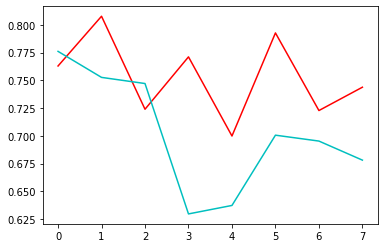

In [39]:
plt.plot(train_scores, 'r')
plt.plot(val_scores, 'c')
plt.show()

## Use GridSearchCV to tune hyperparameter set on SVR

In [ ]:
print(f"Start time: {datetime.now()}")
svr_parameters = {'kernel':['rbf','linear'],'C':[0.1,1,10],'tol':[1e-2, 1e-3, 1e-4]}
svr_grid_search = GridSearchCV(SVR(),svr_parameters, cv=5)
svr_grid_search_result = svr_grid_search.fit(data,labels_raw)
print(f"Best parameters for SVR: {svr_grid_search_result.best_params_}")
print(f"End time: {datetime.now()}")

In [ ]:
svr_reg_cv = SVR(C=10, gamma=0.001, kernel='linear', max_iter=15, tol=0.001)
svr_reg_cv_scores = cross_val_score(svr_reg_cv, data, labels_raw, cv=8)
svr_reg_cv_scores

In [ ]:
import sys
!{sys.executable} -m pip install skrebate
from skrebate import ReliefF
print(f"Start time: {datetime.now()}")
# Using ReliefF to rank features by importance
reg = make_pipeline(ReliefF(n_features_to_select=4, n_neighbors=100),
                    SVR())

print(np.mean(cross_val_score(reg, original_data[:500,:], original_labels[:500,0])))
print(f"End time: {datetime.now()}")

In [ ]:
original_data[:5000,:].shape